# Early Retirement Planner

---

## Environment Setup

In [26]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

---

## Portfolio Planner

In this activity, you will try adjusting the portfolio to either include more risk (a higher stock than bond ratio) or to have a larger initial investment and rerun the retirement analysis to see what it would take to retire in 5 years instead of 30. 

In [27]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv("c:/Users/Sungwon Kim/Fintech/.env")

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

## Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [28]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

## Simulation 1: Get the result and compare it with the previous retirement plan to see what needs to be done.

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame. Run the same Monte Carlo simulation with 5 years period instead of 30.

---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of `500` iterations and generate `5` years of closing prices

In [29]:
# Calculate the daily roi for the stocks
daily_return = df.pct_change()

# Display sample data
daily_return.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,NaN,NaN
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844


In [30]:
# Compute daily volatility
# average daily_returns of two stocks 
avg_daily_return_agg = daily_return.mean()['AGG']['close']
avg_daily_return_spy = daily_return.mean()['SPY']['close']
avg_daily_return_agg

0.00021276976507473064

In [31]:
# standard deviations for two stocks
std_dev_agg = daily_return.std()['AGG']['close']
std_dev_spy = daily_return.std()['SPY']['close']
std_dev_spy

0.007820053413439366

In [32]:
# Save the last day's closing price
agg_closing_price = df['AGG']['close'][-1]
spy_closing_price = df['SPY']['close'][-1]
spy_closing_price

321.92

In [33]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 5  # 5 years
monte_carlo = pd.DataFrame()

In [34]:
# Run the Monte Carlo Simulation
# Initialize empty DataFrame to hold simulated prices for each simulation
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `500` times
for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_agg_prices = [agg_closing_price]
    simulated_spy_prices = [spy_closing_price]
    # Simulate the returns for 252 days * 5 years
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append the simulated prices of each simulation to DataFrame
    monte_carlo["AGG prices"] = pd.Series(simulated_agg_prices)
    monte_carlo["SPY prices"] = pd.Series(simulated_spy_prices)
   
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = monte_carlo.pct_change()
    
    # Set the portfolio weights (60% AGG; 40% SPY)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)

    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

portfolio_cumulative_returns.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1256,1.533586,1.929584,2.158953,1.908002,1.744205,2.376767,1.768656,2.134336,2.312182,1.675762,...,2.183540,1.917404,1.544508,1.789670,2.035667,1.848124,1.571444,1.612906,2.493939,2.001126
1257,1.536824,1.937681,2.154044,1.904015,1.745818,2.390434,1.782674,2.135015,2.324357,1.674341,...,2.195348,1.919050,1.545796,1.791101,2.036488,1.861761,1.571245,1.612742,2.494234,2.003911
1258,1.533675,1.952916,2.159117,1.901269,1.740103,2.389102,1.785865,2.134075,2.322986,1.676690,...,2.190406,1.916053,1.548685,1.780990,2.029833,1.852094,1.566612,1.617661,2.487803,2.006272
1259,1.533871,1.941973,2.156044,1.895436,1.747274,2.391182,1.780914,2.143295,2.319496,1.677168,...,2.189317,1.924457,1.550213,1.793482,2.028147,1.846760,1.566040,1.623314,2.480416,1.997557
1260,1.534022,1.935314,2.155695,1.896760,1.753624,2.395397,1.776837,2.139510,2.311403,1.682227,...,2.187286,1.922152,1.553282,1.792758,2.030798,1.843496,1.572513,1.623186,2.496926,1.993399


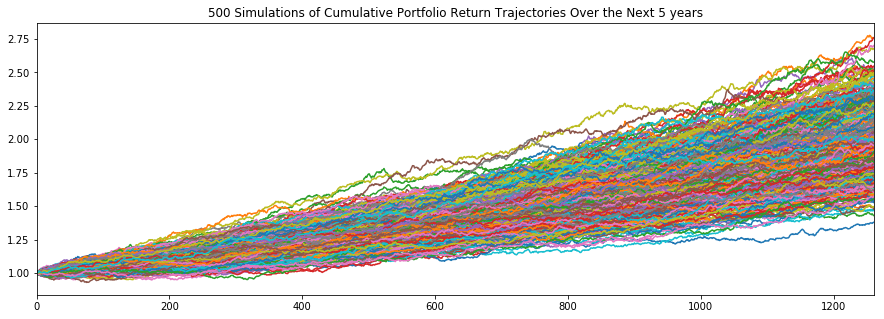

In [35]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 5 years"
portfolio_cumulative_returns.plot(legend=None, title = plot_title, figsize=(15,5) )

In [36]:
# Select the last row for the cumulative returns (cumulative returns at 5 years)
ending_portfolio_prices = portfolio_cumulative_returns.iloc[-1, :]

# Select the last row for the cumulative returns (cumulative returns at 5 years)
ending_portfolio_prices.value_counts(bins=10) / len(ending_portfolio_prices)

# Display the 90% confidence interval for the ending returns
confidence_interval = ending_portfolio_prices.quantile(q= [0.05, 0.95])

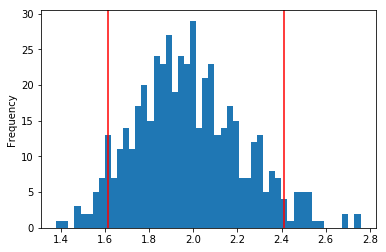

In [37]:
# Visualize the distribution of the ending returns
plt.figure();
ending_portfolio_prices.plot(kind='hist', bins=50)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [38]:
# Set initial investment
initial_investment = 20000
# Compute expected portfolio return
expected_dollar_return_10th_percentile = round(initial_investment * (ending_portfolio_prices.quantile(0.1)), 2)
expected_dollar_return_50th_percentile = round(initial_investment * (ending_portfolio_prices.quantile(0.5)), 2)
expected_dollar_return_90th_percentile = round(initial_investment * (ending_portfolio_prices.quantile(0.9)), 2)
print(f"The expected cumulative returns at 30 years in dollars at the 10th percentile is ${expected_dollar_return_10th_percentile:,},")
print(f"50th percentile is ${expected_dollar_return_50th_percentile:,} and 90th percentile is ${expected_dollar_return_90th_percentile:,}.")

The expected cumulative returns at 30 years in dollars at the 10th percentile is $33,626.65,
50th percentile is $39,358.4 and 90th percentile is $46,213.47.


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

In [39]:
# Set Plaid's projected income
projected_yearly_income = 6085  # From the previous session, we found that the projected yearly income from the Plaid was $6085 (after tax)

# Calculate the 4% withdrawal for the ending return as retirement income
withdraw_rate = 0.04
retirement_income = round(expected_dollar_return_10th_percentile * withdraw_rate, 2)

# Determine if the retirement income meets or exceeds the current projected income
if retirement_income >= projected_yearly_income:
    print(f'The retirement income meets or exceeds the current projected annual income by ${retirement_income - projected_yearly_income:,}')
else:
    print(f'The retirement income does not meet or exceed the current projected annual income, falling short of ${projected_yearly_income - retirement_income:,}')

The retirement income does not meet or exceed the current projected annual income, falling short of $4,739.93


## Simulation 2: Increase the initial investment

In this step, you will need to increase the initial investment while holding the portfolio same as Simulation 1, to see what it would take to retire in 5 years.

In [66]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
initial_investment_increase = 20000 * 4.6
# Compute expected portfolio return
expected_dollar_return_10th_percentile_increase = round(initial_investment_increase * (ending_portfolio_prices.quantile(0.1)), 2)
retirement_income = round(expected_dollar_return_10th_percentile_increase * withdraw_rate, 2)
# Determine if the retirement income meets or exceeds the current projected income
if retirement_income >= projected_yearly_income:
    print(f'The retirement income meets or exceeds the current projected annual income by ${retirement_income - projected_yearly_income:,.2f}')
else:
    print(f'The retirement income does not meet or exceed the current projected annual income, falling short of ${projected_yearly_income - retirement_income:,}')

The retirement income meets or exceeds the current projected annual income by $102.30


## Simulation 3: Include more risk by substituting 'AGG' to a riskier stock than bond ratio and compare the result with the Simulation 1

In this step, you will need to substitute 'AGG' to a higher risk stock than bond ratio to see what result would be and compare it with the result of Simulation 1.

In [44]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker_new = ["SPY", "AMD"]  # picked 'AMD'(Advanced Micro Devices, Inc) because it was one of the highest-beta stocks in S&P500

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df_new = api.get_barset(
    ticker_new,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df_new = df_new.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [46]:
# Calculate the daily roi for the stocks
daily_return_new = df_new.pct_change()

# Display sample data
daily_return_new.head()

,AMD,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,NaN,NaN
2019-01-03 00:00:00-05:00,-0.091533,-0.021730
2019-01-04 00:00:00-05:00,0.109824,0.032521
2019-01-07 00:00:00-05:00,0.084607,0.007884
2019-01-08 00:00:00-05:00,0.008505,0.008844


In [49]:
# Compute daily volatility
# average daily_returns of new stock 
avg_daily_return_amd = daily_return_new.mean()['AMD']['close']

# standard deviations for new stock
std_dev_amd = daily_return_new.std()['AMD']['close']

# Save the last day's closing price
amd_closing_price = df_new['AMD']['close'][-1]

amd_closing_price

45.87

In [50]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 5  # 5 years
monte_carlo_new = pd.DataFrame()

In [51]:
# Run the Monte Carlo Simulation
# Initialize empty DataFrame to hold simulated prices for each simulation
portfolio_cumulative_returns_new = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `500` times
for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_amd_prices = [amd_closing_price]
    simulated_spy_prices = [spy_closing_price]
    # Simulate the returns for 252 days * 5 years
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_amd_price = simulated_amd_prices[-1] * (1 + np.random.normal(avg_daily_return_amd, std_dev_amd))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_spy))
        
        # Append the simulated price to the list
        simulated_amd_prices.append(simulated_amd_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append the simulated prices of each simulation to DataFrame
    monte_carlo_new["AMD prices"] = pd.Series(simulated_amd_prices)
    monte_carlo_new["SPY prices"] = pd.Series(simulated_spy_prices)
   
    # Calculate the daily returns of simulated prices
    simulated_daily_returns_new = monte_carlo_new.pct_change()
    
    # Set the portfolio weights (60% AMD; 40% SPY)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns_new = simulated_daily_returns_new.dot(weights)

    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns_new[n] = (1 + portfolio_daily_returns_new.fillna(0)).cumprod()

portfolio_cumulative_returns_new.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1256,8.697212,48.221947,51.430934,219.916664,17.699534,7.953994,17.539740,16.399512,106.440523,42.796170,...,9.271739,112.367441,39.118892,15.086918,24.998941,57.921141,21.640145,22.987446,16.051885,11.558935
1257,8.838660,47.292943,52.366627,220.567071,17.531167,7.907773,17.950481,16.271288,109.020767,42.686510,...,9.560862,113.154630,39.137381,14.857275,25.405946,60.189076,21.786628,22.482308,15.960261,11.418328
1258,8.775755,46.460467,51.164120,225.900907,17.711954,8.171369,17.080387,16.636894,110.115205,42.040872,...,9.359107,114.941095,38.993723,15.172750,25.758540,59.905687,21.979294,21.445682,16.576480,11.187648
1259,9.091190,44.124018,51.407206,224.476827,17.657549,8.153036,17.575447,16.711599,112.298010,42.297979,...,9.494922,113.386412,38.915698,14.941092,25.554801,60.285210,21.586456,21.608738,16.790787,11.494887
1260,9.413729,43.280712,50.780699,225.734720,18.018914,8.294111,17.374883,17.242044,116.969240,41.972828,...,9.400070,113.058637,39.711254,15.279914,25.899834,60.381953,21.391950,21.922346,17.157024,11.452549


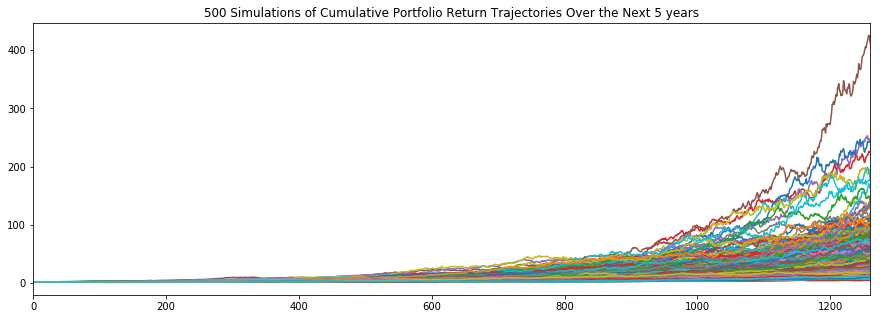

In [52]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 5 years"
portfolio_cumulative_returns_new.plot(legend=None, title = plot_title, figsize=(15,5) )

In [59]:
# Select the last row for the cumulative returns (cumulative returns at 5 years)
ending_portfolio_prices_new = portfolio_cumulative_returns_new.iloc[-1, :]

# Select the last row for the cumulative returns (cumulative returns at 5 years)
ending_portfolio_prices_new.value_counts(bins=10) / len(ending_portfolio_prices)

# Display the 90% confidence interval for the ending returns
confidence_interval_new = ending_portfolio_prices_new.quantile(q= [0.05, 0.95])

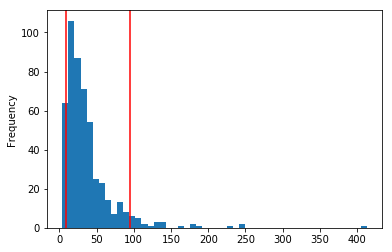

In [60]:
# Visualize the distribution of the ending returns
plt.figure();
ending_portfolio_prices_new.plot(kind='hist', bins=50)
plt.axvline(confidence_interval_new.iloc[0], color='r')
plt.axvline(confidence_interval_new.iloc[1], color='r')

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [61]:
# Set initial investment
initial_investment = 20000
# Compute expected portfolio return
expected_dollar_return_10th_percentile_new = round(initial_investment * (ending_portfolio_prices_new.quantile(0.1)), 2)
expected_dollar_return_50th_percentile_new = round(initial_investment * (ending_portfolio_prices_new.quantile(0.5)), 2)
expected_dollar_return_90th_percentile_new = round(initial_investment * (ending_portfolio_prices_new.quantile(0.9)), 2)
print(f"The expected cumulative returns at 5 years in dollars at the 10th percentile is ${expected_dollar_return_10th_percentile_new:,},")
print(f"50th percentile is ${expected_dollar_return_50th_percentile_new:,} and 90th percentile is ${expected_dollar_return_90th_percentile_new:,}.")

The expected cumulative returns at 5 years in dollars at the 10th percentile is $222,679.62,
50th percentile is $549,726.56 and 90th percentile is $1,510,972.24.


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

In [65]:
# Set Plaid's projected income
projected_yearly_income = 6085  # From the previous session, we found that the projected yearly income from the Plaid was $6085 (after tax)

# Calculate the 4% withdrawal for the ending return as retirement income
withdraw_rate = 0.04
retirement_income_new = round(expected_dollar_return_10th_percentile_new * withdraw_rate, 2)

# Determine if the retirement income meets or exceeds the current projected income
if retirement_income_new >= projected_yearly_income:
    print(f'The retirement income meets or exceeds the current projected annual income by ${retirement_income_new - projected_yearly_income:,.2f}')
else:
    print(f'The retirement income does not meet or exceed the current projected annual income, falling short of ${projected_yearly_income - retirement_income_new:,}')

The retirement income meets or exceeds the current projected annual income by $2,822.18


## Conclusion

In **Simulation 1**, the expected cumulative returns at 5 years in dollars at the 10th percentile is **USD33,626**, 50th percentile is **USD39,358** and 90th percentile is **USD46,213**. The early retirement income does not meet or exceed the current projected annual income, *falling short of* **USD4,740**. This means you need to take a necessary step to revise your existing retirement plan.

Accordingly, we did the **Simulation 2** by increasing the amount of initial investment. We found that the retirement income meets or exceeds the current projected annual income by USD102.30, *only when the initial investment increased by* **460% or USD72,000**(= USD92,000 - USD20,000).

In **Simulation 3**, by the way, the expected cumulative returns significantly increased, the result showed that the returns at the 10th percentile is **USD222,679**,
50th percentile is **USD549,726** and 90th percentile is **USD1,510,972**. The retirement income **meets or exceeds** the current projected annual income by **USD2,822**, which means you do not need to add more money in your planned initial investment.

In conclusion, we recommend that you either adjust your initial investment up to 92,000 unless you want to take more risk than the current portfolio, or you change your portfolio so as to boost your expected return by increasing your risk-appetite by substituting 'AGG' stock to 'AMD' without increasing initial investment.